# Student Pass/Fail Classification using ANN
## Using nn.Linear and nn.ReLU for Binary Classification

### 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('student_performance_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (708, 10)

First few rows:


,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
0,S147,Male,31,68.267841,86,High School,Yes,Yes,63,Pass
1,S136,Male,16,78.222927,73,PhD,No,No,50,Fail
2,S209,Female,21,87.525096,74,PhD,Yes,No,55,Fail
3,S458,Female,27,92.076483,99,Bachelors,No,No,65,Pass
4,S078,Female,37,98.655517,63,Masters,No,Yes,70,Pass


In [3]:
# Dataset information
print("Dataset info:")
df.info()
print("\nTarget distribution:")
df['Pass_Fail'].value_counts()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  708 non-null    object 
 1   Gender                      708 non-null    object 
 2   Study_Hours_per_Week        708 non-null    int64  
 3   Attendance_Rate             708 non-null    float64
 4   Past_Exam_Scores            708 non-null    int64  
 5   Parental_Education_Level    708 non-null    object 
 6   Internet_Access_at_Home     708 non-null    object 
 7   Extracurricular_Activities  708 non-null    object 
 8   Final_Exam_Score            708 non-null    int64  
 9   Pass_Fail                   708 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 55.4+ KB

Target distribution:


Pass_Fail
Pass    354
Fail    354
Name: count, dtype: int64

### 3. Data Preprocessing

In [4]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home', 
                       'Extracurricular_Activities']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Encode target variable
target_encoder = LabelEncoder()
df['Pass_Fail'] = target_encoder.fit_transform(df['Pass_Fail'])
print(f"Pass_Fail: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Parental_Education_Level: {'Bachelors': np.int64(0), 'High School': np.int64(1), 'Masters': np.int64(2), 'PhD': np.int64(3)}
Internet_Access_at_Home: {'No': np.int64(0), 'Yes': np.int64(1)}
Extracurricular_Activities: {'No': np.int64(0), 'Yes': np.int64(1)}
Pass_Fail: {'Fail': np.int64(0), 'Pass': np.int64(1)}


In [5]:
# Select features (excluding Student_ID and target)
feature_columns = ['Gender', 'Study_Hours_per_Week', 'Attendance_Rate', 
                   'Past_Exam_Scores', 'Parental_Education_Level', 
                   'Internet_Access_at_Home', 'Extracurricular_Activities', 
                   'Final_Exam_Score']

X = df[feature_columns].values
y = df['Pass_Fail'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (708, 8)
Target shape: (708,)


In [ ]:
# Split the data
# stratify is used to maintain the same distribution of classes in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print("Data preprocessing completed!")

Train set: (566, 8), Test set: (142, 8)
Data preprocessing completed!


### 4. Create Dataset and DataLoader

In [7]:
# Create custom Dataset
class StudentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
train_dataset = StudentDataset(X_train_tensor, y_train_tensor)
test_dataset = StudentDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 18
Number of test batches: 5


### 5. Define the ANN Model using nn.Linear and nn.ReLU

In [8]:
class StudentANN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=2):
        super(StudentANN, self).__init__()
        
        # Define layers using nn.Linear
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(hidden_size3, output_size)
        
    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
model = StudentANN(input_size=input_size)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Model Architecture:
StudentANN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)

Total parameters: 3218


### 6. Define Loss Function and Optimizer

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam with learning rate 0.001")

Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.001


### 7. Train the Model

In [10]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    train_losses = []
    train_accuracies = []
    
    print("Training the model...")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Train the model
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=100)

Training the model...
Epoch [10/100], Loss: 0.0426, Accuracy: 99.65%
Epoch [20/100], Loss: 0.0075, Accuracy: 100.00%
Epoch [30/100], Loss: 0.0023, Accuracy: 100.00%
Epoch [40/100], Loss: 0.0010, Accuracy: 100.00%
Epoch [50/100], Loss: 0.0006, Accuracy: 100.00%
Epoch [60/100], Loss: 0.0004, Accuracy: 100.00%
Epoch [70/100], Loss: 0.0002, Accuracy: 100.00%
Epoch [80/100], Loss: 0.0002, Accuracy: 100.00%
Epoch [90/100], Loss: 0.0001, Accuracy: 100.00%
Epoch [100/100], Loss: 0.0001, Accuracy: 100.00%


### 8. Evaluate the Model

In [11]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Evaluate on test set
y_pred, y_true = evaluate_model(model, test_loader)
test_accuracy = accuracy_score(y_true, y_pred)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

Test Accuracy: 99.30%

Classification Report:
              precision    recall  f1-score   support

        Fail       0.99      1.00      0.99        71
        Pass       1.00      0.99      0.99        71

    accuracy                           0.99       142
   macro avg       0.99      0.99      0.99       142
weighted avg       0.99      0.99      0.99       142


Confusion Matrix:
[[71  0]
 [ 1 70]]


### 9. Visualize Results

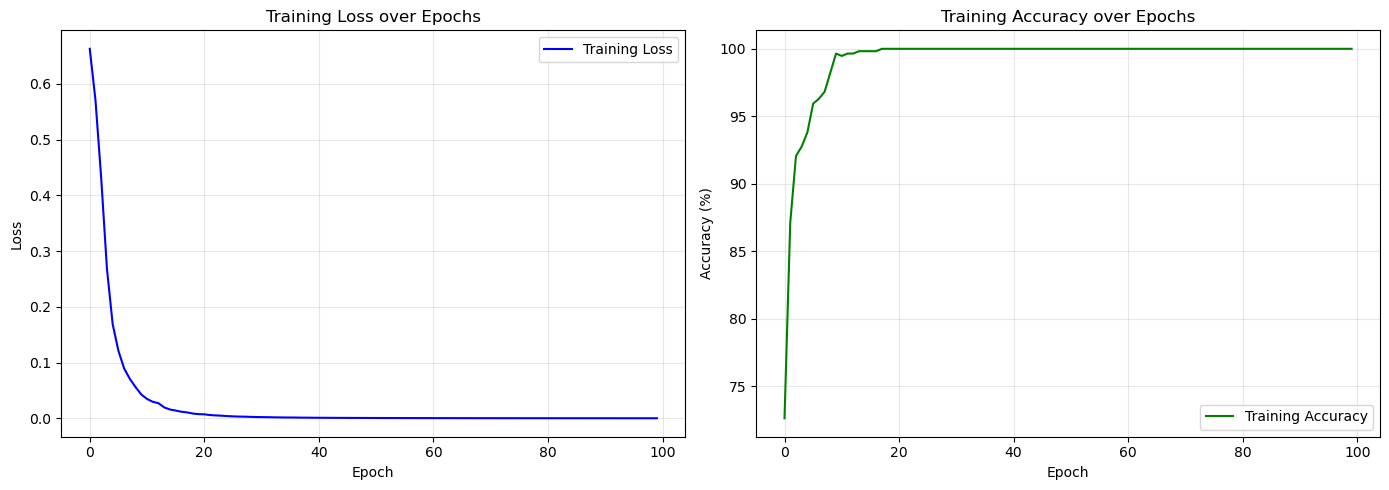

In [12]:
# Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accuracies, label='Training Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy over Epochs')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

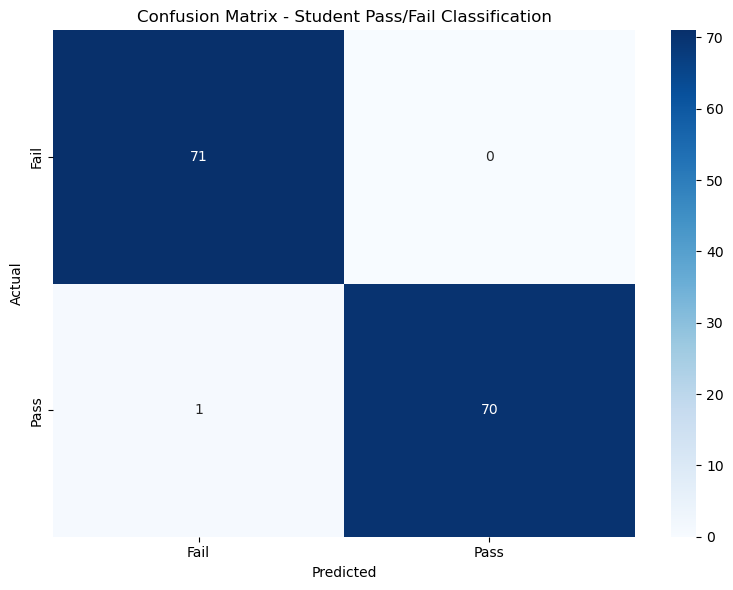

In [13]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Student Pass/Fail Classification')
plt.tight_layout()
plt.show()

### 10. Save the Model

In [14]:
# Save the model
torch.save(model.state_dict(), 'student_ann_model.pth')
print("Model saved: student_ann_model.pth")

# Save preprocessing objects
import pickle
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'feature_columns': feature_columns
}
with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)
print("Preprocessing objects saved: preprocessing_objects.pkl")

Model saved: student_ann_model.pth
Preprocessing objects saved: preprocessing_objects.pkl


### 11. Make Predictions on New Data (Example)

In [16]:
# Example: Make prediction on a new student
# Features: Gender, Study_Hours_per_Week, Attendance_Rate, Past_Exam_Scores, 
#           Parental_Education_Level, Internet_Access_at_Home, Extracurricular_Activities, Final_Exam_Score

# Example student data (before encoding)
example_student = {
    'Gender': 'Male',
    'Study_Hours_per_Week': 1,
    'Attendance_Rate': 85.5,
    'Past_Exam_Scores': 78,
    'Parental_Education_Level': 'Bachelors',
    'Internet_Access_at_Home': 'Yes',
    'Extracurricular_Activities': 'Yes',
    'Final_Exam_Score': 30
}

# Encode the example
example_encoded = [
    label_encoders['Gender'].transform([example_student['Gender']])[0],
    example_student['Study_Hours_per_Week'],
    example_student['Attendance_Rate'],
    example_student['Past_Exam_Scores'],
    label_encoders['Parental_Education_Level'].transform([example_student['Parental_Education_Level']])[0],
    label_encoders['Internet_Access_at_Home'].transform([example_student['Internet_Access_at_Home']])[0],
    label_encoders['Extracurricular_Activities'].transform([example_student['Extracurricular_Activities']])[0],
    example_student['Final_Exam_Score']
]

# Scale and convert to tensor
example_scaled = scaler.transform([example_encoded])
example_tensor = torch.FloatTensor(example_scaled)

# Make prediction
model.eval()
with torch.no_grad():
    output = model(example_tensor)
    _, predicted = torch.max(output, 1)
    prediction = target_encoder.inverse_transform(predicted.numpy())[0]

print(f"Prediction for example student: {prediction}")

Prediction for example student: Fail
